In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# calculating derivatives analytically of very basic functions
![](imgs/deriv_formula.png)

first we start off with a simple quadratic $3x^2 - 4x + 5$,

and then move on to calculating the derivative of $d = a * b + c$ w.r.t. each input (a, b, and c)

In [3]:
def f(x):
    return 3*(x**2) - 4*x + 5

In [4]:
f(3.0)

20.0

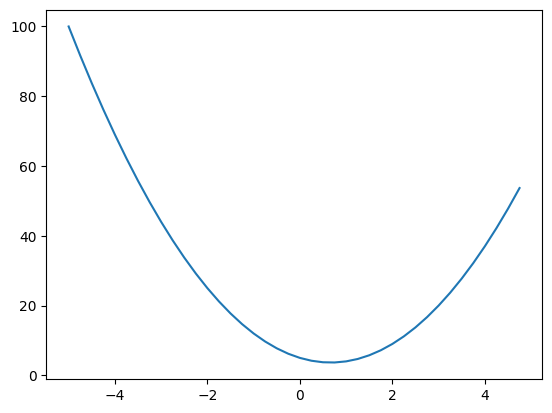

In [5]:
xs = np.arange(-5, 5, 0.25)
ys =f(xs)
_ = plt.plot(xs, ys)

In [6]:
# calculating the deriv of f using the lim def (h) - numerical approx.
h = 0.000001
x = 3
(f(x+h)-f(x)) / h 

14.000003002223593

In [7]:
# more complex case, (a,b,c) -> d
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
# calculating the deriv of d w.r.t. the input values
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# deriv:
d1 = a*b + c
a += h
d2 = a*b + c
print(f'd1 = {d1}')
print(f'd2 = {d2}')
print(f'slope = {(d2-d1)/h}')

d1 = 4.0
d2 = 3.999699999999999
slope = -3.000000000010772


# Engine
Value class

In [38]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # 0 means no effect
        self._backward = lambda: None # default an empty func
        self._prev = set(_children) #set for efficiency 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # supports: a + 1
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # supports: 1 + a
        return self + other
    
    def __sub__(self, other):
        return self + -1*other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # supports: a * 1
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # supports: 2 * a
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # self / other
        return self * (other**-1)

    def exp(self):
        n = self.data
        t = math.exp(n) # t = e^n
        out = Value(t, (self, ), 'exp')
        def _backward():
            self.grad += t * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1) # t = tanh(n)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        n = self.data
        t = n if n>0 else 0 # t = relu(n) = max(0,n)
        out = Value(t, (self, ), 'relu')
        def _backward():
            self.grad += (1 if n>0 else 0) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # to do an automatic backward step on a full graph, we will use topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


## examples

In [44]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


### example 1: mul and add nodes

In [40]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
print(f'd: {d}')
print(f'd\'s children are {d._prev}, that were {d._op} together')

f = Value(-2.0, label='f')
L = d * f; L.label='L'
L


d: Value(data=4.0)
d's children are {Value(data=-6.0), Value(data=10.0)}, that were + together


Value(data=-8.0)

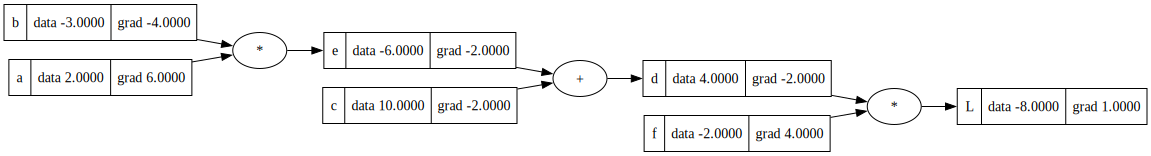

In [43]:
draw_dot(L)

Using the chain rule: 
* add node: $\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} = \frac{dL}{dd} * \frac{d(c+e)}{dc} = \frac{dL}{dd} * 1 = \frac{dL}{dd}$
$\rightarrow$ add node backpropagates the derivative.

* mul node: $\frac{dL}{da} = \frac{dL}{de} * \frac{de}{da} = \frac{dL}{de} * \frac{d(a*b)}{da} = \frac{dL}{dc} * b $
$\rightarrow$ mul node backpropagates the derivative by mul by the value of the other node.

Manual calculations of the backward pass:
* $\frac{dL}{dL} = 1$
  
* $\frac{dL}{df} =_{mul} \frac{dL}{dL} * d = 1 * 4 = 4$
* $\frac{dL}{dd} =_{mul} \frac{dL}{dL} * f = 1 * -2 = -2$
* $\frac{dL}{dc} =_{add} \frac{dL}{dd} = -2$
* $\frac{dL}{de} =_{add} \frac{dL}{dd} = -2$
* $\frac{dL}{db} =_{mul} \frac{dL}{de} * a = -2 * 2 = -4$
* $\frac{dL}{da} =_{mul} \frac{dL}{de} * b = -2 * -3= 6$

In [13]:
# manual backward step
L.grad = 1
f.grad = 4; d.grad = -2
c.grad = -2; e.grad = -2
b.grad = -4; a.grad = 6

In [42]:
# automatic backward step
L.grad = 1.0; L._backward()
d._backward()
e._backward()

forward step (in the direction of the gradient so to *increase L*)

In [14]:
# notice that we can only control the leaf nodes (which are the inputs)
# update to the inputs:
mu = 0.01
a.data += mu * a.grad
b.data += mu * b.grad
c.data += mu * c.grad
f.data += mu * f.grad

# forward pass:
e = a * b
d = e + c
L = d * f

# did L increase like we wanted? yes.
print(f'value of L after a backward and forward pass: {L.data}')


value of L after a backward and forward pass: -7.286496


### example 2: tanh node

Text(0.5, 1.0, 'tanh activation function')

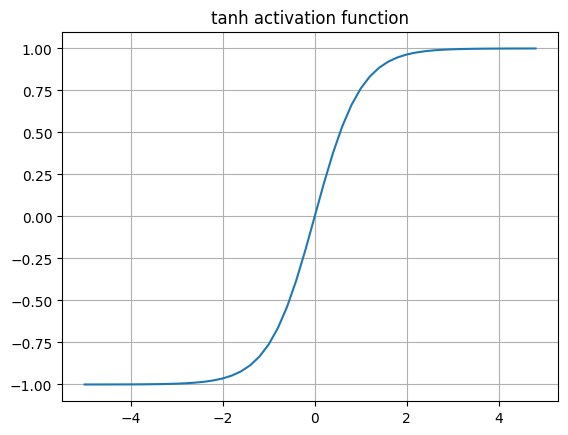

In [15]:
# tanh 
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.title("tanh activation function")

neuron setup

In [51]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587, label='b')
# x1*w1 + x2*w2 + b -> n
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2+b; n.label = 'n'

o = n.tanh(); o.label = "o"


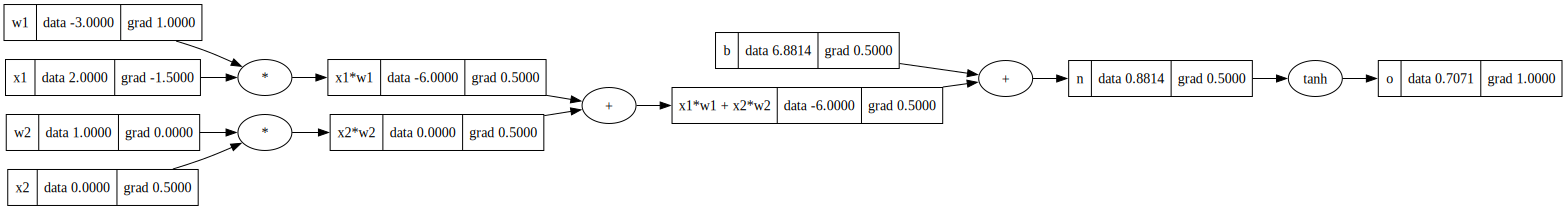

In [54]:
draw_dot(o)

chain rule:
* o.grad = $\frac{do}{do} = 1$
  
* n.grad = $\frac{do}{dn} = \frac{d(tanh(n))}{dn} = 1 - tanh^2(n) = 1 - (\text{o.data})^2 = 1 - 0.5 = 0.5$
* b.grad = $\frac{do}{db} =_{add} \text{n.grad} = 0.5$
* x1w1x2w2.grad = $\frac{do}{dx1w1x2w2} =_{add} \text{n.grad} = 0.5$
* x1w1.grad = $\frac{do}{dx1w1} =_{add} \text{x1w1x2w2.grad} = 0.5$
* x2w2.grad = $\frac{do}{dx2w2} =_{add} \text{x1w1x2w2.grad} = 0.5$
* x1.grad = $\frac{do}{dx1} =_{mul} \text{x1w1.grad} * \text{w1.data} = 0.5 * -3 = -1.5$
* w1.grad = $\frac{do}{dw1} =_{mul} \text{x1w1.grad} * \text{x1.data} = 0.5 * 2 = 1$
* x2.grad = $\frac{do}{dx2} =_{mul} \text{x2w2.grad} * \text{w2.data} = 0.5 * 1 = 0.5$
* w2.grad = $\frac{do}{dw2} =_{mul} \text{x2w2.grad} * \text{x2.data} = 0.5 * 0 = 0$

In [19]:
# manual backward pass:
o.grad = 1
n.grad = 0.5
b.grad = 0.5; x1w1x2w2.grad = 0.5
x1w1.grad = 0.5; x2w2.grad = 0.5
x1.grad = -1.5; w1.grad = 1
x2.grad = 0.5; w2.grad = 0


In [38]:
# (manual) auto backward pass:
o.grad = 1.0; o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward(); x2w2._backward()


In [53]:
# auto backward pass:
o.backward()

same graph as before but we will break down tanh into its definition: $tanh(x) = \frac{e^{2x}-1}{e^{2x}+1}$

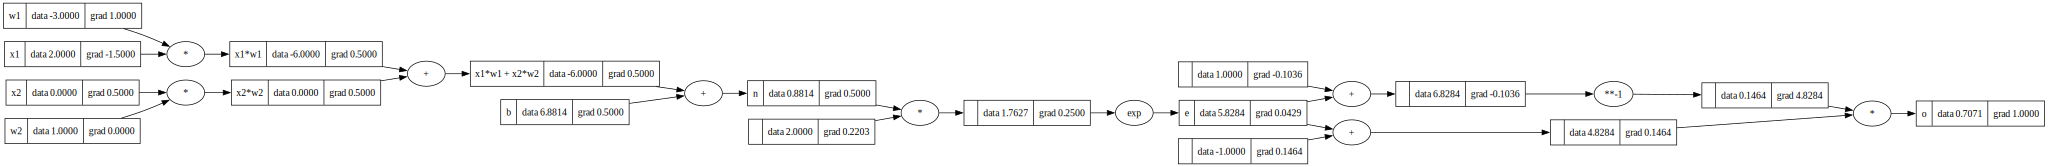

In [80]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587, label='b')
# x1*w1 + x2*w2 + b -> n
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2+b; n.label = 'n'
# ----
e = (2*n).exp(); e.label = "e"
o = (e-1) / (e+1); o.label = "o"
# ----
o.backward()
draw_dot(o)


### example 3: pytorch

In [92]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.881373587]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print(f'x2.grad: {x2.grad.item()}')
print(f'w2.grad: {w2.grad.item()}')
print(f'x1.grad: {x1.grad.item()}')
print(f'w1.grad: {w1.grad.item()}')


0.7071066904050358
----
x2.grad: 0.5000001283844369
w2.grad: 0.0
x1.grad: -1.5000003851533106
w1.grad: 1.0000002567688737


# Building and training a neural net 

<img src="imgs/neuron_dia.png" alt="Neuron Diagram" width="300"/>


In [3]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]


In [66]:
# example
x = [2.0, 3.0]
n = Neuron(2)
print(n.parameters())
n(x)

[Value(data=-0.6481772864400683), Value(data=-0.037574153498890484), Value(data=-0.5683115805119945)]


Value(data=-0.9623947528943239)

MLP:

<img src="imgs/layer_dia.png" alt="Neuron Diagram" width="300"/>


In [4]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [72]:
# example
x = [1,2,3]
n = Layer(3, 5)
# print(n.parameters())
n(x)

[Value(data=0.7731788750231402),
 Value(data=0.4430152555869283),
 Value(data=-0.9867772415377251),
 Value(data=0.19705490118327776),
 Value(data=0.989742911486434)]

In [5]:
class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [46]:
x = [1,2,3]
n = MLP(3, [4,4,1])
print(n(x))
# draw_dot(n(x))

Value(data=0.8910526283307268)


## simple example training an mlp

In [47]:
# dataset, each example in xs is a row with a dim of 3.
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [75]:
mlp = MLP(3, [4,4,1])
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.05837824234384646),
 Value(data=-0.7857370386602898),
 Value(data=0.5092998949646135),
 Value(data=-0.8722495700333605)]

In [77]:
len(mlp.parameters())

41

In [76]:
# loss - MSE
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.715864776523823)

In [78]:
# want to minimize the loss
loss.backward()

In [79]:
mlp.layers[0].neurons[0].w[0].grad

-2.7653774399297193

In [80]:
mlp.layers[0].neurons[0].w[0].data

0.37408635395199163

In [61]:
# draw_dot(loss)

In [97]:
# gradient descent manually over the mlp params
for p in mlp.parameters():
    p.data += -0.1 * p.grad # against the dir of the gradient 

In [100]:
mlp.layers[0].neurons[0].w[0].data

0.7612391955421522

In [98]:
# did the loss end up going down after a gd step? yes
ypred = [mlp(x) for x in xs] # forward pass
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.856017413375893)

In [99]:
ypred

[Value(data=0.9588695293062547),
 Value(data=-0.12471390247569725),
 Value(data=0.04013515327400468),
 Value(data=0.9205090686886619)]

In [106]:
# init the neural net
mlp = MLP(3, [4,4,1])
# automatic gd:
for k in range(20):
    # forward pass
    ypred = [mlp(x) for x in xs]

    # evaluate the loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(f'step: {k}, loss: {loss}')

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += -0.1 * p.grad 


step: 0, loss: Value(data=4.350902744209016)
step: 1, loss: Value(data=3.5266316541213225)
step: 2, loss: Value(data=3.1626345391760884)
step: 3, loss: Value(data=3.1735157598152797)
step: 4, loss: Value(data=2.621252049215856)
step: 5, loss: Value(data=3.4983233267592513)
step: 6, loss: Value(data=0.6444850469926184)
step: 7, loss: Value(data=0.35580843228410375)
step: 8, loss: Value(data=0.20673523734952864)
step: 9, loss: Value(data=0.15920928982957577)
step: 10, loss: Value(data=0.1299029248174464)
step: 11, loss: Value(data=0.10939411905149964)
step: 12, loss: Value(data=0.09426315450266955)
step: 13, loss: Value(data=0.08265932466505595)
step: 14, loss: Value(data=0.07349083845153981)
step: 15, loss: Value(data=0.0660724892015137)
step: 16, loss: Value(data=0.05995288985345816)
step: 17, loss: Value(data=0.05482280779768424)
step: 18, loss: Value(data=0.05046343066669402)
step: 19, loss: Value(data=0.04671565935053446)


In [107]:
ypred # at the end of training

[Value(data=0.9116954677252946),
 Value(data=-0.9282730080057586),
 Value(data=-0.8608814727757773),
 Value(data=0.87991984788192)]

## complex example of training an mlp

In [6]:
from sklearn.datasets import make_moons, make_blobs
np.random.seed(1337)
random.seed(1337)

num of training examples: 100


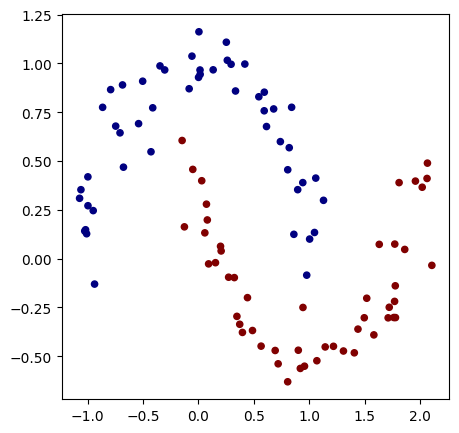

In [24]:
# dataset creation
X, y = make_moons(n_samples=100, noise=0.1)
# y has 0s and 1s, we want -1s and 1s
y = y*2 - 1
# plot:
plt.figure(figsize=(5,5))
_ = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')
print(f'num of training examples: {X.shape[0]}')

In [66]:
# model init
model = MLP(2, [16,16,1]) # 2 layer mlp
print(f'num of params in model: {len(model.parameters())}')

num of params in model: 337


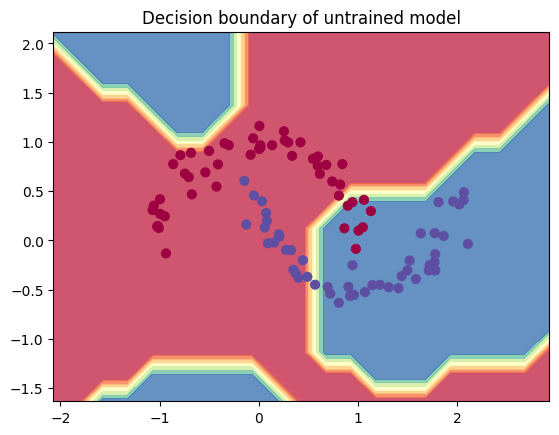

In [67]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
_ = plt.title("Decision boundary of untrained model")

In [46]:
# loss function
def loss(batch_size=None):
    if batch_size == None:
        Xb, yb = X, y #take the whole dataset as the batch
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] # array of indexes for the batch
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb] # make the batch into Values

    # forward the model to get scores
    scores = list(map(model, inputs)) #model(input) for input in inputs

    # svm max-margin loss
    losses = [(1+ -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 reg.
    alpha = 1e-4
    reg_loss = alpha * sum(p*p for p in model.parameters())
    total_loss = data_loss + reg_loss

    # accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    
    return total_loss, sum(accuracy) / len(accuracy)

        

In [68]:
# train loop:
for k in range(100):
    # forward pass
    total_loss, acc = loss(batch_size=50)

    # backward pass
    for p in model.parameters():
        p.grad = 0.0
    total_loss.backward()

    # update
    lr = 1.0 - 0.9* k/100
    for p in model.parameters():
        p.data -= lr * p.grad

    if k%1 == 0:
        print(f'step {k+1} with lr {lr:.3f}, loss: {total_loss.data:.3f}, accuracy: {int(acc*100)}')

step 1 with lr 1.000, loss: 0.823, accuracy: 76
step 2 with lr 0.991, loss: 0.284, accuracy: 88
step 3 with lr 0.982, loss: 0.249, accuracy: 88
step 4 with lr 0.973, loss: 0.349, accuracy: 82
step 5 with lr 0.964, loss: 0.301, accuracy: 84
step 6 with lr 0.955, loss: 0.261, accuracy: 92
step 7 with lr 0.946, loss: 0.232, accuracy: 92
step 8 with lr 0.937, loss: 0.161, accuracy: 94
step 9 with lr 0.928, loss: 0.271, accuracy: 86
step 10 with lr 0.919, loss: 0.234, accuracy: 90
step 11 with lr 0.910, loss: 0.230, accuracy: 92
step 12 with lr 0.901, loss: 0.217, accuracy: 90
step 13 with lr 0.892, loss: 0.211, accuracy: 88
step 14 with lr 0.883, loss: 0.109, accuracy: 98
step 15 with lr 0.874, loss: 0.246, accuracy: 92
step 16 with lr 0.865, loss: 0.324, accuracy: 84
step 17 with lr 0.856, loss: 0.250, accuracy: 90
step 18 with lr 0.847, loss: 0.155, accuracy: 98
step 19 with lr 0.838, loss: 0.230, accuracy: 92
step 20 with lr 0.829, loss: 0.124, accuracy: 94
step 21 with lr 0.820, loss: 

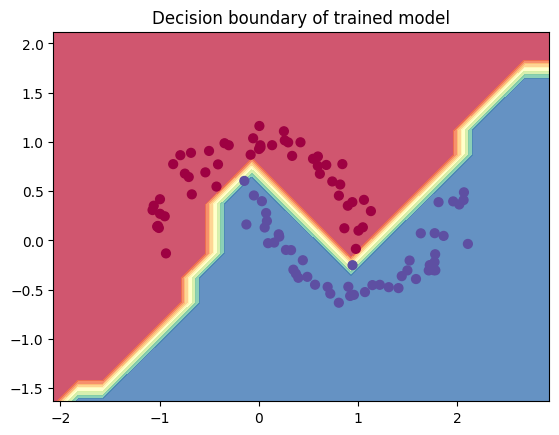

In [69]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
_ = plt.title("Decision boundary of trained model")